In [1]:
import torch
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import resample
import pandas as pd
import numpy as np
import evaluate
from datetime import datetime

In [2]:
from transformers import AutoTokenizer, get_scheduler, AutoModelForSequenceClassification

model_choice = 'bert'  # 'bert', 'distilbert', 'albertina'
train_size = 100000 # Terá 50% de cada label
batch_size = 32 # tamanho do batch pro treino (32 funciona pro bert, pra roBerTa é menos, isso tem a ver com a VRAM necessária)
max_length = 256 # tamanho máximo das sequencias de entrada pro modelo, se a entrada for maior, ele trunca.
num_workers = 8 # quantidade de workers (maior mais memoria gasta mais rapido o treino)
num_epochs = 3

In [3]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast('cuda'):
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    return total_loss / len(data_loader)

def evaluateModel(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            if logits.shape[1] == 1:  # Binary classification case
                predictions = (logits > 0).long().squeeze(1)  # Convert logits to binary predictions
            else:
                predictions = torch.argmax(logits, dim=1)  # Multiclass case
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_pred = (np.array(all_predictions), np.array(all_labels))
    metrics = compute_metrics(eval_pred)
    return total_loss / len(data_loader), metrics

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [5]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) if predictions.ndim > 1 else (predictions > 0).astype(int)
    
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    precision_score = precision.compute(predictions=predictions, references=labels, average="weighted")
    recall_score = recall.compute(predictions=predictions, references=labels, average="weighted")
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)

    return {
        'f1': f1_score['f1'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall'],
        'accuracy': accuracy_score['accuracy'],
    }

In [6]:
accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")

df = pd.read_parquet('../reviews/reviews_cleaned.parquet')

num_samples = min(train_size, df['label'].value_counts().min())
undersampled_dfs = []

for label in df['label'].unique():
    df_label = df[df['label'] == label]
    if len(df_label) > num_samples:
        df_label = resample(df_label, 
                            replace=False, 
                            n_samples=num_samples, 
                            random_state=42)
    undersampled_dfs.append(df_label)

df = pd.concat(undersampled_dfs)

train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)

timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M")

if model_choice == 'bert':
    model_name = "neuralmind/bert-base-portuguese-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model_save_path = f'../models/bert_model_{timestamp}_{train_size*2}'
    tokenizer_save_path = f'../models/bert_tokenizer_{timestamp}_{train_size*2}'
elif model_choice == 'albertina':
    model_name = "PORTULAN/albertina-100m-portuguese-ptbr-encoder"
    tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model_save_path = f'../models/albertina-ptbr_model_{timestamp}_{train_size*2}'
    tokenizer_save_path = f'../models/albertina-ptbr_tokenizer_{timestamp}_{train_size*2}'
elif model_choice == 'distilbert':
    model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
    tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
    model_save_path = f'../models/distilbert_model_{timestamp}_{train_size*2}'
    tokenizer_save_path = f'../models/distilbert_tokenizer_{timestamp}_{train_size*2}'
else:
    raise ValueError("Modelo desconhecido! Escolha entre 'bert', 'distilbert', ou 'albertina'.")


train_dataset = SentimentDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer, max_length=max_length)
val_dataset = SentimentDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer, max_length=max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * num_epochs
)

scaler = GradScaler('cuda')

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}:")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_metrics = evaluateModel(model, val_loader, device)
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"Validation F1: {val_metrics['f1']:.4f}")
    print(f"Validation Precision: {val_metrics['precision']:.4f}")
    print(f"Validation Recall: {val_metrics['recall']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:


Training: 100%|████████████████████████████████████████████████████████████| 5625/5625 [29:18<00:00,  3.20it/s]


Training Loss: 0.2694
Validation Loss: 0.2383
Validation Accuracy: 0.9051
Validation F1: 0.9051
Validation Precision: 0.9051
Validation Recall: 0.9051
Epoch 2:


Training: 100%|████████████████████████████████████████████████████████████| 5625/5625 [29:24<00:00,  3.19it/s]


Training Loss: 0.1876
Validation Loss: 0.2418
Validation Accuracy: 0.9073
Validation F1: 0.9072
Validation Precision: 0.9073
Validation Recall: 0.9073
Epoch 3:


Training: 100%|████████████████████████████████████████████████████████████| 5625/5625 [29:23<00:00,  3.19it/s]


Training Loss: 0.1153
Validation Loss: 0.2842
Validation Accuracy: 0.9049
Validation F1: 0.9049
Validation Precision: 0.9049
Validation Recall: 0.9049


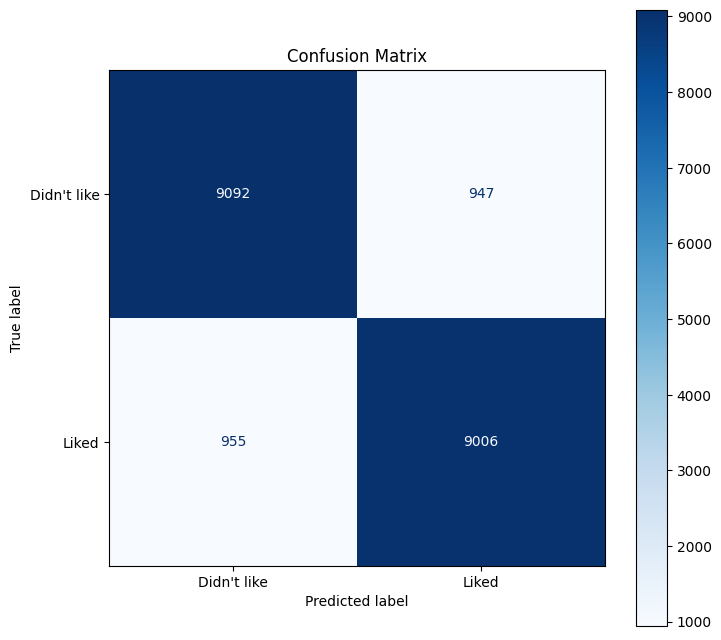

In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_preds
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Didn't like", "Liked"])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [8]:
print(f"Modelo salvo em: {model_save_path}")
print(f"Tokenizador salvo em: {tokenizer_save_path}")
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

Modelo salvo em: ../models/bert_model_15-08-2024-16-06_200000
Tokenizador salvo em: ../models/bert_tokenizer_15-08-2024-16-06_200000


('../models/bert_tokenizer_15-08-2024-16-06_200000/tokenizer_config.json',
 '../models/bert_tokenizer_15-08-2024-16-06_200000/special_tokens_map.json',
 '../models/bert_tokenizer_15-08-2024-16-06_200000/vocab.txt',
 '../models/bert_tokenizer_15-08-2024-16-06_200000/added_tokens.json',
 '../models/bert_tokenizer_15-08-2024-16-06_200000/tokenizer.json')

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

new_sample = "pra ser um jogo ruim tenque melhora mt ainda"

inputs = tokenizer(new_sample, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

inputs = {key: value.to(device) for key, value in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

label_map = {0: "Negative", 1: "Positive"}
print(f"Prediction: {label_map[prediction]}")


Prediction: Negative


In [16]:
new_sample = "eu amei esse jogo estou viciado"

inputs = tokenizer(new_sample, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

inputs = {key: value.to(device) for key, value in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

label_map = {0: "Negative", 1: "Positive"}
print(f"Prediction: {label_map[prediction]}")

Prediction: Positive
